# 📊 Session 6: Text Classification

**Learning Objectives:**
- Understand different text classification algorithms (MultinomialNB, SVM, Logistic Regression)
- Implement train/test split and cross-validation
- Evaluate models using confusion matrix, F1-score, and other metrics
- Practice multi-class text classification
- Compare model performance and select the best approach

**Dataset:** We'll work with news articles, product reviews, and custom datasets

---

## 🛠️ Setup and Imports

🎬 Movie Reviews Sentiment Classification: Complete Solution


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
     Neutral       0.00      0.00      0.00         1
    Positive       1.00      1.00      1.00         1

    accuracy                           0.33         3
   macro avg       0.33      0.33      0.33         3
weighted avg       0.33      0.33      0.33         3



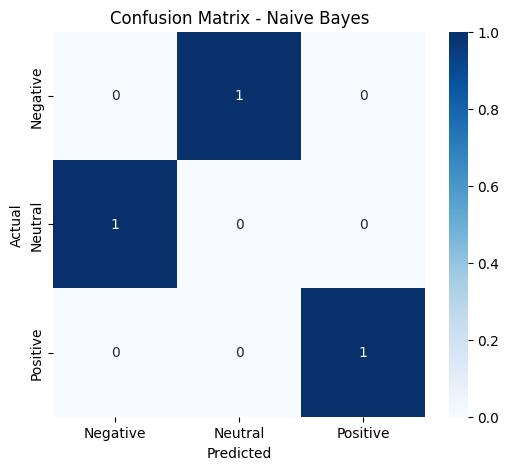


Training and cross-validating Naive Bayes ...
F1 Macro CV Mean: 0.222 | Std: 0.211

Training and cross-validating Logistic Regression ...
F1 Macro CV Mean: 0.222 | Std: 0.211

Training and cross-validating SVM (Linear) ...
F1 Macro CV Mean: 0.222 | Std: 0.211

Training and cross-validating Random Forest ...
F1 Macro CV Mean: 0.078 | Std: 0.097

Training and cross-validating K-Nearest Neighbors ...
F1 Macro CV Mean: 0.278 | Std: 0.141


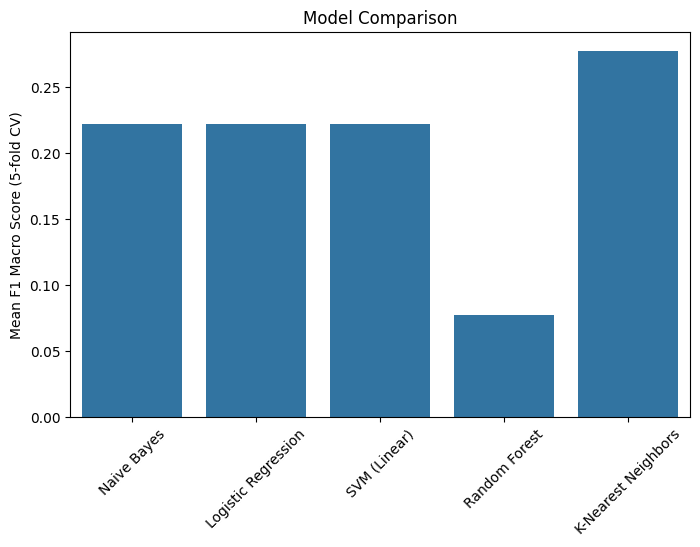

CountVectorizer (unigrams): F1 Macro CV Mean=0.222
TF-IDF (unigrams): F1 Macro CV Mean=0.222
TF-IDF (bigrams): F1 Macro CV Mean=0.167
TF-IDF (unigrams + bigrams): F1 Macro CV Mean=0.222
TF-IDF (char 3-5 grams): F1 Macro CV Mean=0.156


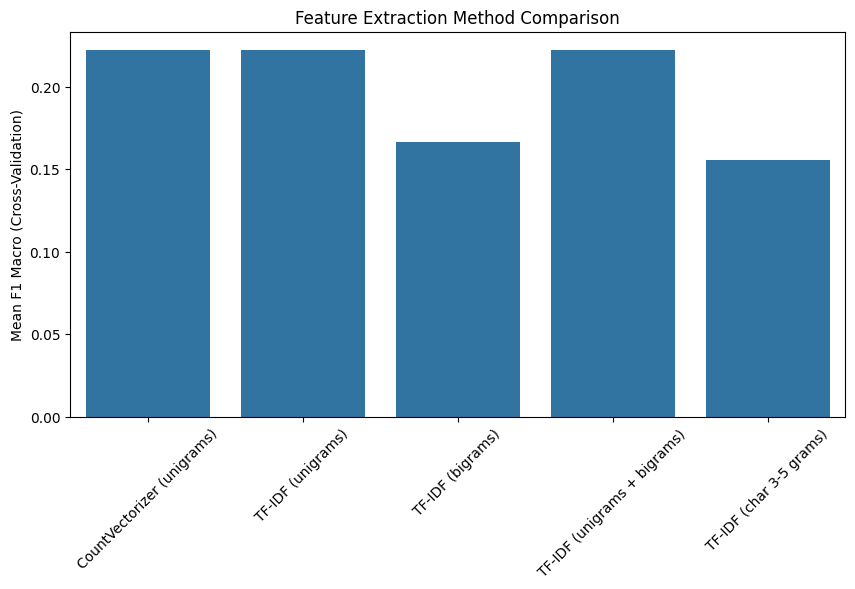

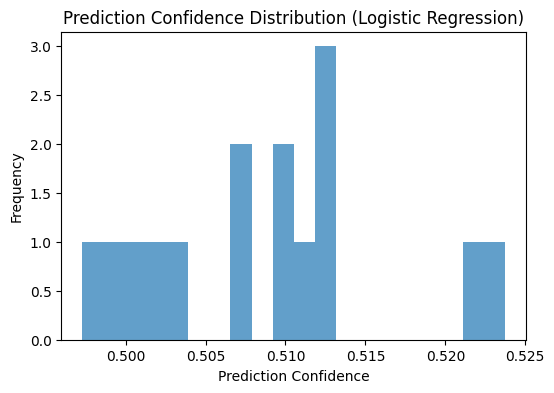

Review: What a fantastic movie! Loved every minute of it.
Predicted Sentiment: Positive, Confidence: 0.363

Review: It was dull and uninteresting. Not worth watching.
Predicted Sentiment: Neutral, Confidence: 0.386

Review: Some scenes were good, but overall just okay.
Predicted Sentiment: Neutral, Confidence: 0.390

Best parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best cross-validated F1 Macro: 0.267


In [4]:
# Required Libraries
import pandas as pd
import numpy as np
import re
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline # Import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Add this line to download the missing resource

# 1. Create Sample Movie Reviews Dataset
def create_movie_review_dataset():
    # Positive reviews
    positive_reviews = [
        "I absolutely loved this film! The story was compelling and the acting superb.",
        "An amazing cinematic experience with brilliant performances.",
        "A heartwarming story that touched me deeply.",
        "Fantastic direction and stunning visuals. Highly recommended!",
        "Top-notch screenplay and incredible soundtrack."
    ]
    # Negative reviews
    negative_reviews = [
        "The movie was boring and slow-paced; I wouldn’t recommend it.",
        "Terrible acting and a predictable script ruined it for me.",
        "Waste of time. The plot made no sense at all.",
        "Poor editing and bad special effects spoiled the experience.",
        "One of the worst movies I have ever watched."
    ]
    # Neutral reviews
    neutral_reviews = [
        "It was an okay movie — nothing special but watchable.",
        "The storyline was average and the characters were decent.",
        "Some parts were entertaining, others quite dull.",
        "Not great, not terrible, just an average film experience.",
        "A middling movie, not memorable but not horrible either."
    ]
    texts = positive_reviews + negative_reviews + neutral_reviews
    labels = (['Positive'] * len(positive_reviews) +
              ['Negative'] * len(negative_reviews) +
              ['Neutral'] * len(neutral_reviews))
    return pd.DataFrame({'text': texts, 'sentiment': labels})

df = create_movie_review_dataset()

# 2. Text Preprocessing Pipeline
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = text.strip()
        return text

    def preprocess(self, text):
        text = self.clean_text(text)
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t not in self.stop_words and len(t) > 2]
        tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        return " ".join(tokens)

preprocessor = TextPreprocessor()
df['processed_text'] = df['text'].apply(preprocessor.preprocess)

# 3. Basic Text Classification Pipeline (Naive Bayes)

# Vectorize text
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['processed_text'])
le = LabelEncoder()
y = le.fit_transform(df['sentiment'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred = nb_model.predict(X_test)

# Evaluation
print("=== Naive Bayes Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)

# Visualize Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# 4. Model Comparison Framework with Cross-Validation

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM (Linear)': SVC(kernel='linear', probability=True),
    'Random Forest': RandomForestClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
for name, model in models.items():
    print(f"\nTraining and cross-validating {name} ...")
    pipeline = Pipeline([
        ('vect', TfidfVectorizer(max_features=1000, ngram_range=(1,2))),
        ('clf', model)
    ])
    scores = cross_val_score(pipeline, df['processed_text'], y, cv=cv, scoring='f1_macro')
    print(f"F1 Macro CV Mean: {scores.mean():.3f} | Std: {scores.std():.3f}")
    results[name] = scores.mean()

# Visualize Model Comparison
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel('Mean F1 Macro Score (5-fold CV)')
plt.title('Model Comparison')
plt.xticks(rotation=45)
plt.show()

# 5. Advanced Feature Engineering - Comparing Vectorizers

vectorizers = {
    'CountVectorizer (unigrams)': CountVectorizer(max_features=1000, ngram_range=(1,1)),
    'TF-IDF (unigrams)': TfidfVectorizer(max_features=1000, ngram_range=(1,1)),
    'TF-IDF (bigrams)': TfidfVectorizer(max_features=1000, ngram_range=(2,2)),
    'TF-IDF (unigrams + bigrams)': TfidfVectorizer(max_features=1000, ngram_range=(1,2)),
    'TF-IDF (char 3-5 grams)': TfidfVectorizer(max_features=1000, analyzer='char', ngram_range=(3,5))
}

feature_results = {}
model_fe = LogisticRegression(max_iter=1000)
for name, vect in vectorizers.items():
    X_vect = vect.fit_transform(df['processed_text'])
    scores = cross_val_score(model_fe, X_vect, y, cv=cv, scoring='f1_macro')
    print(f"{name}: F1 Macro CV Mean={scores.mean():.3f}")
    feature_results[name] = scores.mean()

# Plot Feature Engineering Results
plt.figure(figsize=(10,5))
sns.barplot(x=list(feature_results.keys()), y=list(feature_results.values()))
plt.xticks(rotation=45)
plt.ylabel('Mean F1 Macro (Cross-Validation)')
plt.title('Feature Extraction Method Comparison')
plt.show()

# 6. Sentiment Classification with Prediction Confidence (Logistic Regression)

pipeline_lr = Pipeline([
    ('vect', TfidfVectorizer(max_features=1000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_lr.fit(df['processed_text'], y)
y_proba = pipeline_lr.predict_proba(df['processed_text'])
max_confidence = np.max(y_proba, axis=1)

# Confidence Distribution Plot
plt.figure(figsize=(6,4))
plt.hist(max_confidence, bins=20, alpha=0.7)
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution (Logistic Regression)')
plt.show()

# Predict with confidence function
def predict_with_confidence(text, pipeline, label_encoder):
    text_proc = preprocessor.preprocess(text)
    probs = pipeline.predict_proba([text_proc])[0]
    pred_idx = np.argmax(probs)
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    confidence = probs[pred_idx]
    return pred_label, confidence

# Test on new reviews
test_texts = [
    "What a fantastic movie! Loved every minute of it.",
    "It was dull and uninteresting. Not worth watching.",
    "Some scenes were good, but overall just okay."
]

for txt in test_texts:
    pred, conf = predict_with_confidence(txt, pipeline_lr, le)
    print(f"Review: {txt}\nPredicted Sentiment: {pred}, Confidence: {conf:.3f}\n")

# 7. Hyperparameter Tuning Example with GridSearchCV (Logistic Regression)

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}

grid_search = GridSearchCV(pipeline_lr, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid_search.fit(df['processed_text'], y)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validated F1 Macro: {grid_search.best_score_:.3f}")

# Use best model
best_model = grid_search.best_estimator_